In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

%matplotlib inline

# From Gaussian Algebra to Gaussian Processes

Most tutorials on Gaussian processes start with a nose-punch of **fancy statements**, like:

- A Gaussian process (GP) defines a distribution over functions.
- A Gaussian process is non-parametric, i.e. it has an infinite number of parameters (duh?).
- Marginalizing a Gaussian over a subset of its elements gives another Gaussian.
- Conditioning a subset of the elements of the Gaussian on another subset gives another Gaussian.

They continue with **fancy terms**, like:

- Kernels
- Knots
- Posterior over functions 
- Squared-exponentials
- Covariances

**Is this really supposed to make sense to the GP beginner?**

The following is the introductory tutorial on GPs that I wish I had myself. The goal is pedagogy — not the waving of **fancy words**.

By the end of this tutorial, you should understand:
- **What a Gaussian process is and how to build one in NumPy** — including those cool, swirly error bars.
- **the motivations behind their functional form**, i.e. how the GP came to be.
- The **fancy statements** above.
- The **fancy words** above.

Let's get started.

## Playing with Gaussians

Before moving within 500 nautical miles of the Gaussian process, we're going to start with something far easier: vanilla Gaussians themselves. This will help us to build intuition. **We'll arrive at the GP before you realize.**

The Gaussian distribution, a.k.a. the Normal distribution, can be thought of as a Python object which:

- Is instantiated with characteristic parameters `mu` (the mean) and `var` (the variance).
- Has a single public method, `density`, which accepts a `float` value `x`, and returns a `float` proportional to the probability of this `Gaussian` having produced `x`.

In [104]:
class Gaussian:
    
    def __init__(self, mu, var):
        self.mu = mu
        self.var = var
        self.stddev = np.sqrt(var)  # the standard deviation is the sqrt of the variance
        
    def density(self, x):
        """
        NB: Understanding the two bullet points above is more important than understanding the following line.
        
        That said, it's just the second bullet in code, via SciPy.
        """
        return norm(loc=self.mu, scale=self.stddev).pdf(x)

So, how do we make those cool bell-shaped plots? **A 2D plot is just a list of tuples — each with an `x`, and a corresponding `y` — shown visually.**

As such, we lay out our `x`-axis, then compute the corresponding `y` — the `density` — for each. We'll choose an arbitrary `mu` and `variance`.

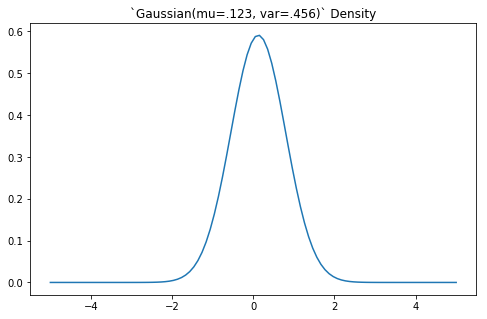

In [35]:
gaussian = Gaussian(mu=.123, var=.456)

x = np.linspace(-5, 5, 100)
y = [gaussian.density(xx) for xx in x]

plt.figure(figsize=(8, 5))
plt.plot(x, y)
_ = plt.title('`Gaussian(mu=.123, var=.456)` Density')

If we increase the variance `var`, what happens?

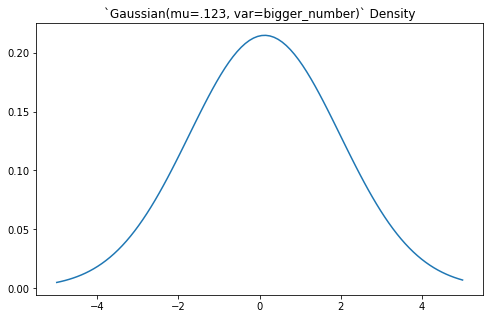

In [36]:
bigger_number = 3.45

gaussian = Gaussian(mu=.123, var=bigger_number)

x = np.linspace(-5, 5, 100)
y = [gaussian.density(xx) for xx in x]

plt.figure(figsize=(8, 5))
plt.plot(x, y)
_ = plt.title('`Gaussian(mu=.123, var=bigger_number)` Density')

The density gets fatter. This should be familiar to you.

Similarly, we can draw *samples* from a `Gaussian` distribution, like the original `Gaussian(mu=.123, var=.456)` distribution. The initial density plot above governs this procedure, where `(x, y)` tuples give the likelihood `y` that a given sample will have the value `x`. 

`x`-values with large corresponding `y`-values are more likely to be sampled. Here, values near 0 are most likely to be sampled. 

Let's add a method to our class, draw 500 samples, then plot a histogram of these samples.

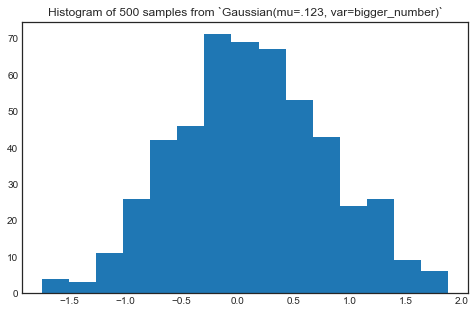

In [73]:
def sample(self):
    return norm(loc=self.mu, scale=self.std).rvs()


# Add method to class
Gaussian.sample = sample

# Instantiate new Gaussian
gaussian = Gaussian(mu=.123, var=.456)

# Draw samples
samples = [gaussian.sample() for _ in range(500)]

# Plot
plt.figure(figsize=(8, 5))
pd.Series(samples).hist(grid=False, bins=15)
_ = plt.title('Histogram of 500 samples from `Gaussian(mu=.123, var=.456)`')

This looks similar to the true `Gaussian(mu=.123, var=.456)` density we plotted above. The more random samples we draw (then plot), the closer this histogram will approximate (look similar to) the true density.

Now, we'll start to move a bit faster.

## 2D Gaussians

We just drew samples from a 1-dimensional Gaussian, i.e. the `sample` itself was a single float. The parameter `mu` dictated the most-likely value for the `sample` to assume, and the variance `var` dictated how much these samples values vary (hence the name variance).

```python
>>> gaussian.sample()
-0.5743030051553177
>>> gaussian.sample()
0.06160509014194515
>>> gaussian.sample()
1.050830033400354
```

In 2D, each sample will be a list of two numbers. `mu` will dictate the most-likely pair of values for the `sample` to assume, and the second parameter (yet unnamed) will dictate:
- How much the values in the first element of the list vary
- How much the values in the second element of the list vary
- How much the first and second elements vary with each other, i.e. if the first element is larger than expected, to what extent does the second element "follow suit"?

The second parameter is the **covariance matrix**, `cov`. The elements on the diagonal give the first two bullet points. The elements off the diagonal give the third. The covariance matrix is always square, and its values are always non-negative.

Given a 2D `mu` and 2x2 `cov`, we can draw samples from the 2D Gaussian. Here, we'll use NumPy. Inline, we comment on the expected shape of the samples.

/Users/willwolf/anaconda3/envs/pyro/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


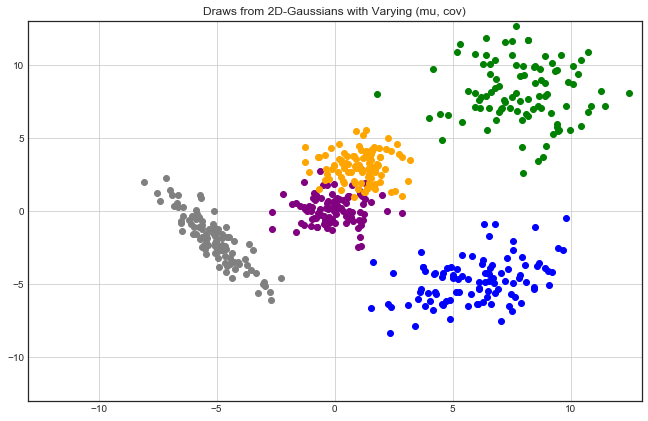

In [103]:
plt.figure(figsize=(11, 7))
plt.ylim(-13, 13)
plt.xlim(-13, 13)


def plot_2d_draws(mu, cov, color, n_draws=100):
    x, y = zip(*[np.random.multivariate_normal(mu, cov) for _ in range(n_draws)])
    plt.scatter(x, y, c=color)


"""
The purple dots should center around `(x, y) = (0, 0)`. `np.diag([1, 1])` gives the covariance matrix `[[1, 0], [0, 1]]`:
`x`-values have a variance of `var=1`; `y`-values have `var=1`; these values do not covary with one another
(e.g. if `x` is larger than its mean, the corresponding `y` have no tendency to "follow suit," i.e. trend larger than its 
mean as well).
"""
plot_2d_draws(
    mu=np.array([0, 0]),
    cov=np.diag([1, 1]),
    color='purple'
)

"""
The blue dots should center around `(x, y) = (1, 3)`. Same story with the covariance.
"""
plot_2d_draws(
    mu=np.array([1, 3]),
    cov=np.diag([1, 1]),
    color='orange'
)

"""
Here, the values along the diagonal of the covariance matrix are much larger: the cloud of green point should be much more
disperse. There is no off-diagonal covariance (`x` and `y` values do not vary — above or below their respective means — *together*).
"""
plot_2d_draws(
    mu=np.array([8, 8]),
    cov=np.diag([4, 4]),
    color='green'
)

"""
The covariance matrix has off-diagonal values of -2. This means that if `x` trends above its mean, `y` will tend to vary *twice as much,
but in the opposite direction, i.e. below its mean.*
"""
plot_2d_draws(
    mu=np.array([-5, -2]),
    cov=np.array([[1, -2], [-2, 3]]),
    color='gray'
)

plot_2d_draws(
    mu=np.array([6, -5]),
    cov=np.array([[2, 4], [4, 2]]),
    color='blue'
)

_ = plt.title('Draws from 2D-Gaussians with Varying (mu, cov)')
plt.grid(True)

## Gaussians are closed under linear maps

The Gaussian for the blue dots tells us the following:

$$
(x, y) \sim \text{Normal}(\mu, \Sigma)
$$

In other words, the draws $(x, y)$ are distributed normally with 2D-mean $\mu$ and 2x2 covariance $\Sigma$.

Let's assume $(x, y)$ is a vector named $w$. Giving subscripts to the parameters of our Gaussian, we can rewrite the above as:

$$
w \sim \text{Normal}(\mu_w, \Sigma_w)
$$

Same thing.

Imagine we have a matrix $A$ of size 200x2. If $w$ is distributed as above, how is $Aw$ distributed? Gaussian algebra tells us the following:

$$
Aw \sim \text{Normal}(\mu_w^T A,\ A^T\Sigma_w A)
$$

In other words, $Aw$, the "linear map" of $w$ onto $A$, is (incidentally) Gaussian-distributed as well.

Let's plot some draws from this distribution. Let's assume each row (2 elements) of $A$ is given by the function:

```python
def make_features(x):
    return np.array([3 * np.cos(x), np.abs(x - np.abs(x - 3))])
```

This function is arbitrary. Given some 200 values along the $x$ axis, we'll use this function to make 2 "features" for each. This will give us a 200x2 matrix $A$. We'll then multiply this matrix by a 2x1 vector of weights, $w$. You can think of this as passing a batch of data through a linear model (where our data have features $x = [x_1, x_2]$, and our parameters are $w = [w_1, w_2]$.

Finally, we'll take draws from this $\text{Normal}(\mu_w^T A,\ A^T\Sigma_w A)$. This will give us tuples of the form `(x, y)`, where:
- `x`: the original `x`-value
- `y`: the value obtained after: making features out of `x`, taking the linear combination of those features with the vector of weights, and taking a draw from our Gaussian.

**Each draw from our Gaussian will yield 200 `y`-values, each corresponding to its original `x`. In other words, it will yield 200 `(x, y)` tuples, which we can plot.**

To make it clear that $A$ was computed as a function of $x$, let's rename it to $A = \phi(x)$. In addition, let's set `mu_w = np.array([0, 0])` and `np.diag([1, 2])`. Finally, we'll take draws, then plot.

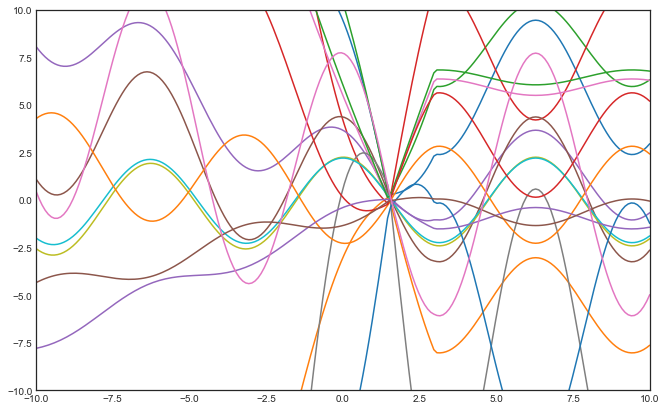

In [107]:
# "Engineer" some features out of `x`
x = np.linspace(-10, 10, 200)
phi_x = np.array([3 * np.cos(x), np.abs(x - np.abs(x - 3))])

mu_w = np.array([0, 0])
cov_w = np.diag([1, 2])

mu_lc = mu_w.T @ phi_x
cov_lc = phi_x.T @ cov_w @ phi_x

plt.figure(figsize=(11, 7))
plt.ylim(-10, 10)
plt.xlim(-10, 10)

for _ in range(17):
    lc = np.random.multivariate_normal(mu_lc, cov_lc)
    plt.plot(x, lc)

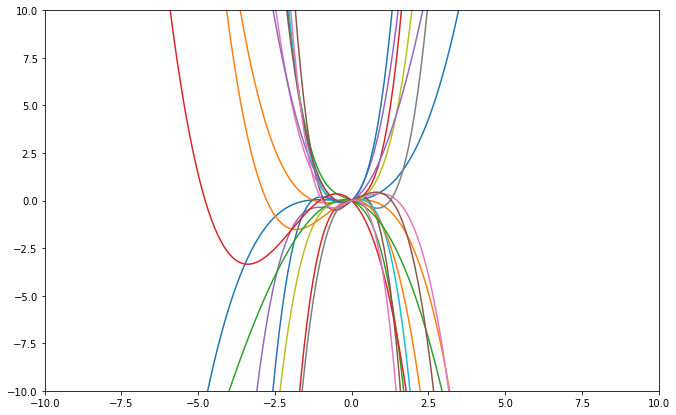

In [254]:
phi_x = np.array([x ** (1 + i) for i in range(3)])

phi_x_dim = len(phi_x)
mu_w = np.zeros(phi_x_dim)
cov_w = 1.1 * np.diag(np.ones(phi_x_dim))

mu_lc = mu_w.T @ phi_x
cov_lc = phi_x.T @ cov_w @ phi_x

plt.figure(figsize=(11, 7))
plt.ylim(-10, 10)
plt.xlim(-10, 10)

for _ in range(17):
    lc = np.random.multivariate_normal(mu_lc, cov_lc)
    plt.plot(x, lc)

In [256]:
# update with some data

In [310]:
x_train = np.array([-5, -2.5, -1, 2, 4, 6])
y_train = np.sin(x_train)**2 - np.abs(x_train - 3) + 7
x_test  = np.linspace(-10, 10, 200)

In [308]:
# show the formula for conditional gaussian, then do it below

In [306]:
def compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test):
    # featurize x_train
    phi_x = phi_func(x_train)
    
    # params of prior distribution over function evals
    mu_y = mu_w.T @ phi_x
    cov_y = phi_x.T @ cov_w @ phi_x

    # params of posterior distribution over weights
    mu_w_post = mu_w + cov_w @ phi_x @ np.linalg.inv(cov_y) @ (y_train - mu_y)
    cov_w_post = cov_w - cov_w @ phi_x @ np.linalg.inv(cov_y) @ phi_x.T @ cov_w

    # featurize x_test
    phi_x_test = phi_func(x_test)

    # params of posterior distribution function evals
    mu_y_post = phi_x_test.T @ mu_w_post
    cov_y_post = phi_x_test.T @ cov_w_post @ phi_x_test
    
    return mu_y_post, cov_y_post


def plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=50):
    plt.figure(figsize=(14, 9))
    plt.ylim(-3, 10)
    plt.xlim(-10, 10)

    var_y_post = np.diag(cov_y_post)
    plt.fill_between(x_test, mu_y_post - var_post, mu_y_post + var_y_post, color='#23AEDB', alpha=.5)
    plt.plot(x_train, y_train, 'ro', markersize=10)
    for _ in range(50):
        y_pred = np.random.multivariate_normal(mu_y_post, cov_y_post)
        plt.plot(x_test, y_pred, alpha=.2)

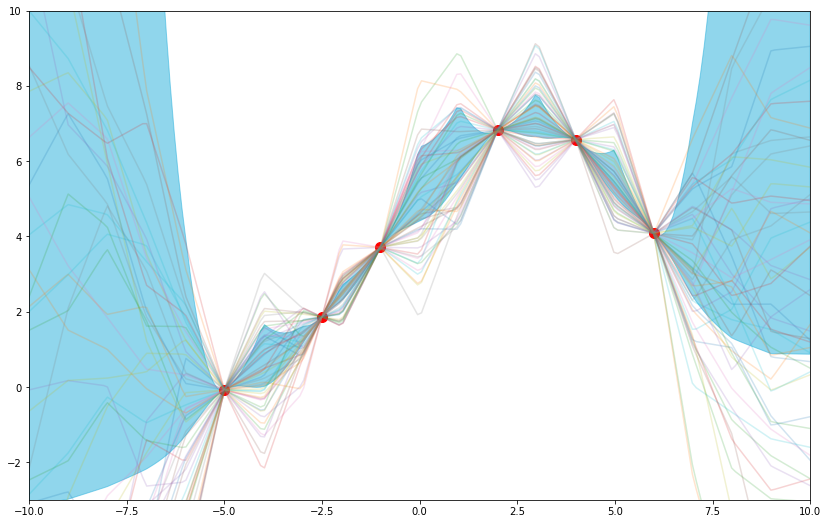

In [317]:
D = 20


# Params of prior distribution over weights
mu_w = np.zeros(D)
cov_w = 1.1 * np.diag(np.ones(D))


def phi_func(x, D=D):
    return np.array([np.abs(x - d) for d in range(int(-D / 2), int(D / 2))])


# Update prior over weights, then prior over function evals, with observed data
mu_y_post, cov_y_post = compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test)

# Plot
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test)

/Users/willwolf/anaconda3/envs/pyro/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: covariance is not positive-semidefinite.


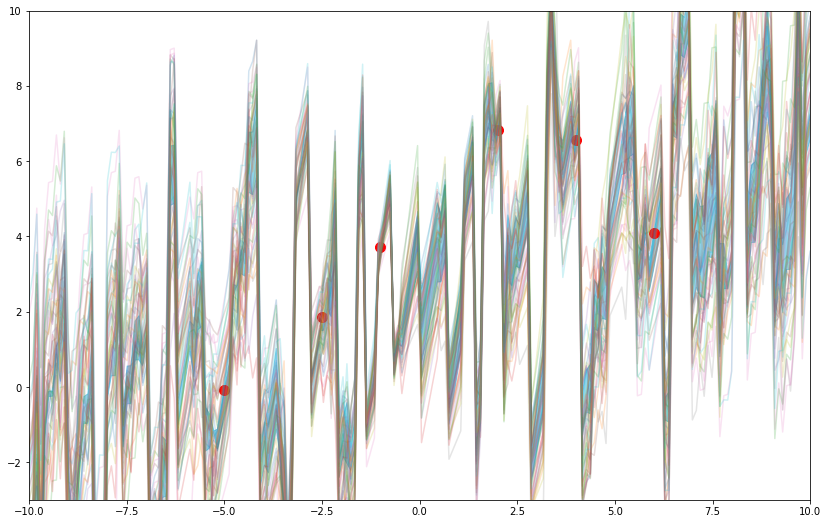

In [318]:
def phi_func(x, D=D):
    return np.array([x // np.log(np.abs(d + .001)) for d in range(int(-D / 2), int(D / 2))])


# Update prior over weights, then prior over function evals, with observed data
mu_y_post, cov_y_post = compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test)

# Plot
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test)

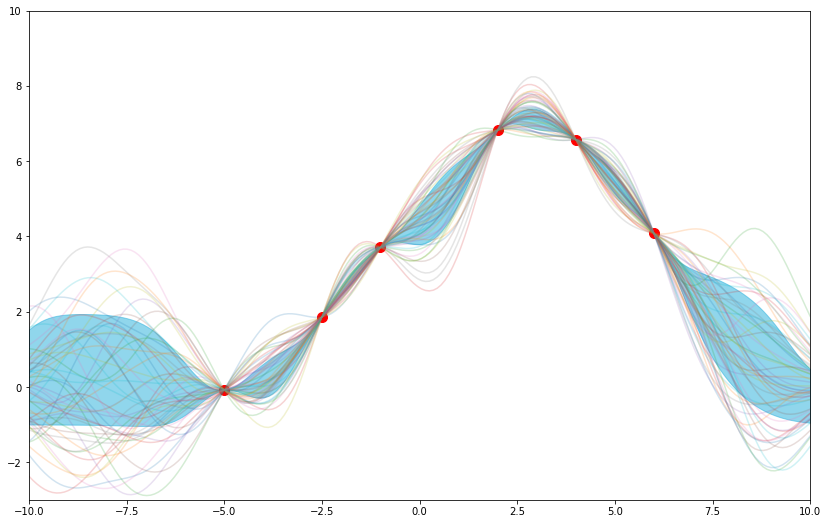

In [319]:
def phi_func(x, D=D):
    return np.array([np.exp(-.5 * (x - d)**2) for d in range(int(-D / 2), int(D / 2))])


# Update prior over weights, then prior over function evals, with observed data
mu_y_post, cov_y_post = compute_gp_posterior(mu_w, cov_w, phi_func, x_train, y_train, x_test)

# Plot
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test)

# infinite features?

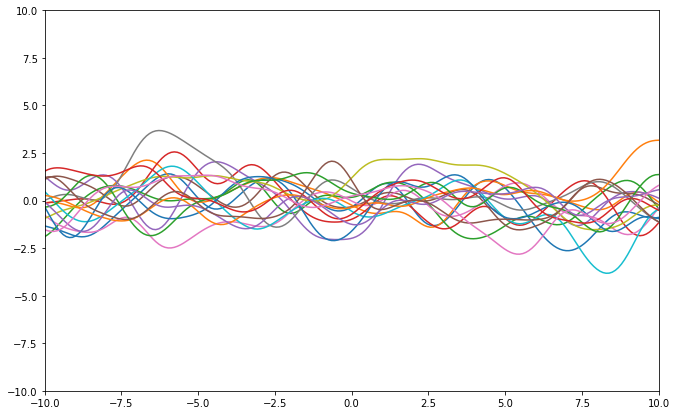

In [297]:
def rbf(a, b, c=1, l=1):
    a = np.expand_dims(a, 1)  # dims: (len(x), 1)
    b = np.expand_dims(b, 0)  # dims: (1, len(b))
    # a - b --> dims: (len(x), len(b))
    return np.exp(c * -.5 * ((a - b) / l)**2)


# mu_w : a vector with an infinite number of 0's
# cov_w : a square matrix with sides of infinite length

x = np.linspace(-10, 10, 200)

mu_lc = np.zeros_like(x)
cov_lc = rbf(x, x)

plt.figure(figsize=(11, 7))
plt.ylim(-10, 10)
plt.xlim(-10, 10)

for _ in range(17):
    lc = np.random.multivariate_normal(mu_lc, cov_lc)
    plt.plot(x, lc)

In [298]:
# analytical posterior, with kernels

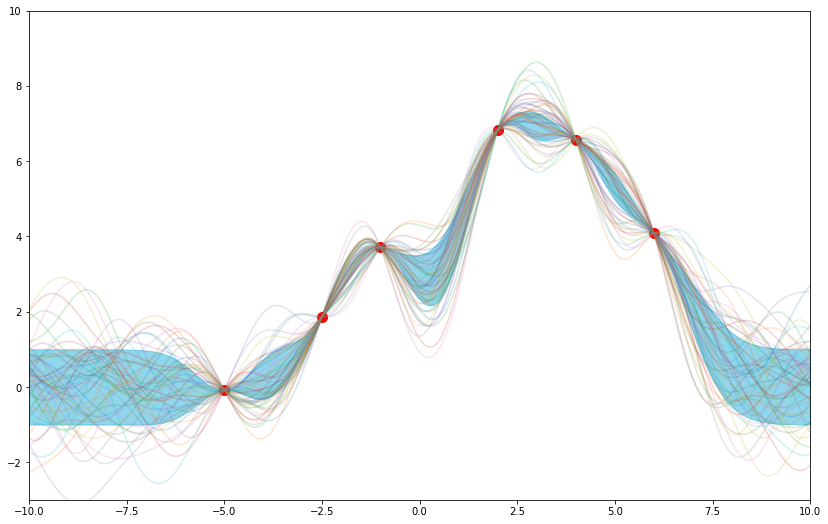

In [323]:
# Update prior over weights, then prior over function evals, with observed data
cov_obs = 0 * \
    np.eye(len(x_train))

A = rbf(x_test, x_train) @ np.linalg.inv(rbf(x_train, x_train) + cov_obs)
mu_y_post  = A @ y_train
cov_y_post = rbf(x_test, x_test) - A @ rbf(x_train, x_test)

# Plot
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test)

# This whole covariance business

In [44]:
# D = 7
# N_OBS = 12

# mu_w = np.random.randn(D)

# 1. we can just make this ourselves:
#    - how does each of the 7 dimensions covary with every other dimension?
#    - for this reason, the thing will always be of size 7 x 7
# 2. we can estimate this from data
#    - numpy docs say: "m : array_like; A 1-D or 2-D array containing multiple variables 
#      and observations. Each row of m represents a variable, and each column a single 
#      observation of all those variables."
#    - this is backwards from what we typically think. nonetheless, our input to np.cov
#      should be of size (D, N_OBS)

# cov_w = np.cov(np.random.randn(D, N_OBS))

# N_OBS_X = 100

# mu_y = np.random.randn(N_OBS_X)  # after passing it through the mean function, which collapses the dimensionality D to 1
# phi_x = np.random.randn(D, N_OBS_X)  # same as above, with D first then N_OBS_X
# cov_y = phi_x.T @ cov_w @ phi_x  # 100 x 100; # we often just compute this directly with RBF kernel; this is the explicit way, which is of course infeasible if `phi` gives inf features!

# # now pluck out your things
# cov_w_y = cov_w @ phi_x  # (7 x 7) @ (7, 100) --> 7, 100
# cov_y_x = phi_x.T @ cov_w  # (100 x 7) @ (7, 7) --> 100, 7

"Centering the process on a linear model, while allowing the process to accommodate deviations from the lienar model, addresses the curse of dimensionality, as the psoterior can concentrate close to the linear moel (or an alternative parametric mean function) to an extent supported by the data"

BDA3, Chapter 21

# $P(y^{*}\vert y)$

(just multiply phi(x_new) through the mean, and wrapped around the covariance)

# kernel regression

In [54]:
# rbf kernel
def rbf(point, neighbor, sigma=.5):
    return np.exp(-(point - neighbor)**2 / (2 * sigma**2))


def query(point, data=data, kernel=rbf):
    weighted_sum = 0
    total_weight = 0
    for x, y in data.items():
        if x != point:
            weight = kernel(point=point, neighbor=x)
            weighted_sum += weight * y
            total_weight += weight
    return weighted_sum / total_weight

In [55]:
y_approx = [query(xx) for xx in x]

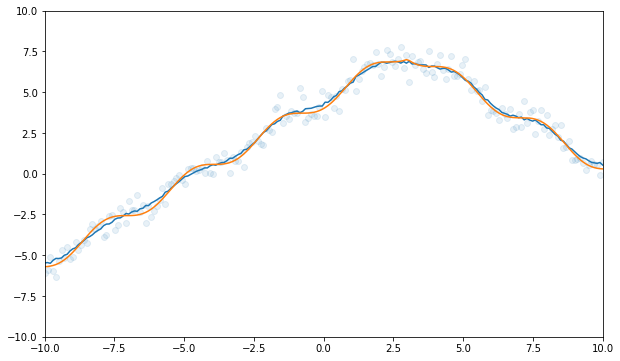

In [56]:
plt.figure(figsize=(10, 6))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.plot(x, y_approx)
plt.plot(x, y_true)
plt.scatter(x, noisy_y_true, alpha=.1)